<a href="https://colab.research.google.com/github/qlqhdl101/Blinking/blob/main/%EB%88%88%EA%B9%9C%EB%B0%95%EC%9E%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip eye_blink_detector-master.zip

Archive:  eye_blink_detector-master.zip
118b15c7a1444411cc823a540b23ad2db94c7167
   creating: eye_blink_detector-master/
 extracting: eye_blink_detector-master/.gitignore  
  inflating: eye_blink_detector-master/README.md  
   creating: eye_blink_detector-master/dataset/
  inflating: eye_blink_detector-master/dataset/dataset.csv  
  inflating: eye_blink_detector-master/dataset/x_train.npy  
  inflating: eye_blink_detector-master/dataset/x_val.npy  
  inflating: eye_blink_detector-master/dataset/y_train.npy  
  inflating: eye_blink_detector-master/dataset/y_val.npy  
  inflating: eye_blink_detector-master/helpers.py  
   creating: eye_blink_detector-master/models/
  inflating: eye_blink_detector-master/models/2018_12_17_22_58_35.h5  
  inflating: eye_blink_detector-master/preprocess.ipynb  
  inflating: eye_blink_detector-master/test.py  
  inflating: eye_blink_detector-master/train.ipynb  
   creating: eye_blink_detector-master/videos/
  inflating: eye_blink_detector-master/videos/1.mp

In [ ]:
!unzip shape_predictor_68_face_landmarks.dat.bz2

Archive:  shape_predictor_68_face_landmarks.dat.bz2
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of shape_predictor_68_face_landmarks.dat.bz2 or
        shape_predictor_68_face_landmarks.dat.bz2.zip, and cannot find shape_predictor_68_face_landmarks.dat.bz2.ZIP, period.


In [ ]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Activation, Conv2D, Flatten,Dense, MaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

plt.style.use('dark_background')

In [ ]:
x_train = np.load('/content/eye_blink_detector-master/dataset/x_train.npy').astype(np.float32)
y_train = np.load('/content/eye_blink_detector-master/dataset/y_train.npy').astype(np.float32)
x_val = np.load('/content/eye_blink_detector-master/dataset/x_val.npy').astype(np.float32)
y_val = np.load('/content/eye_blink_detector-master/dataset/y_val.npy').astype(np.float32)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(2586, 26, 34, 1) (2586, 1)
(288, 26, 34, 1) (288, 1)


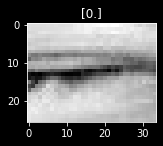

In [ ]:
plt.subplot(2,1,2)
plt.title(str(y_val[4]))
plt.imshow(x_val[4].reshape((26,34)),cmap='gray')

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(
    x = x_train,y = y_train,
    batch_size = 32,
    shuffle = True
)

val_generator = val_datagen.flow(
    x = x_val, y = y_val,
    batch_size = 32,
    shuffle = False
)

In [ ]:
pip install keras --upgrade

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.4.3)


In [ ]:
inputs = Input(shape=(26, 34, 1))

net = Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(inputs)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = MaxPooling2D(pool_size=2)(net)

net = Flatten()(net)

net = Dense(512)(net)
net = Activation('relu')(net)
net = Dense(1)(net)
outputs = Activation('sigmoid')(net)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 26, 34, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 34, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 17, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 17, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 8, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 4, 128)         0     

In [ ]:
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

model.fit_generator(
    train_generator, epochs=50, validation_data=val_generator,
    callbacks=[ 
        ModelCheckpoint('models/%s.h5' % (start_time), monitor='val_acc', save_best_only=True, mode='max', verbose=1),
        ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)
    ]
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
81/81 [==============================] - 7s 80ms/step - loss: 0.5449 - acc: 0.7068 - val_loss: 0.2164 - val_acc: 0.9201

Epoch 00001: val_acc improved from -inf to 0.92014, saving model to models/2021_02_09_07_51_21.h5
Epoch 2/50
81/81 [==============================] - 6s 77ms/step - loss: 0.2437 - acc: 0.9089 - val_loss: 0.1600 - val_acc: 0.9271

Epoch 00002: val_acc improved from 0.92014 to 0.92708, saving model to models/2021_02_09_07_51_21.h5
Epoch 3/50
81/81 [==============================] - 6s 77ms/step - loss: 0.1830 - acc: 0.9295 - val_loss: 0.0979 - val_acc: 0.9653

Epoch 00003: val_acc improved from 0.92708 to 0.96528, saving model to models/2021_02_09_07_51_21.h5
Epoch 4/50
81/81 [==============================] - 6s 78ms/step - loss: 0.1510 - acc: 0.9441 - val_loss: 0.0497 - val_acc: 0.9757

Epoch 00004: val_acc improved from 0.96528 to 0.97569, saving model to models/2021_02_09_07_51_21.h5
Epoch 5/50
81/81 [==============================] - 6s 77ms/step - loss

test acc: 1.0


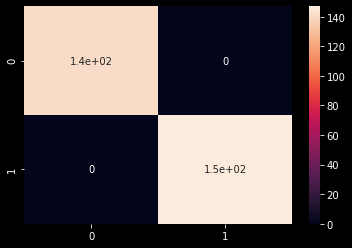

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

model = load_model('models/%s.h5' % (start_time))

y_pred = model.predict(x_val/255.)
y_pred_logical = (y_pred > 0.5).astype(np.int)

print ('test acc: %s' % accuracy_score(y_val, y_pred_logical))
cm = confusion_matrix(y_val, y_pred_logical)
sns.heatmap(cm, annot=True)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


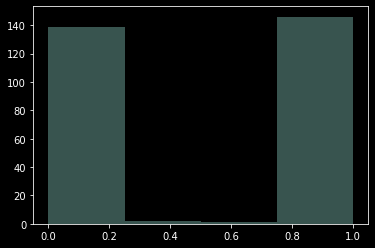

In [ ]:
ax = sns.distplot(y_pred, kde=False)

In [ ]:
import cv2, dlib
import numpy as np
from imutils import face_utils
from keras.models import load_model

IMG_SIZE = (34, 26)

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

model = load_model('models/2018_12_17_22_58_35.h5')
model.summary()

def crop_eye(img, eye_points):
  x1, y1 = np.amin(eye_points, axis=0)
  x2, y2 = np.amax(eye_points, axis=0)
  cx, cy = (x1 + x2) / 2, (y1 + y2) / 2

  w = (x2 - x1) * 1.2
  h = w * IMG_SIZE[1] / IMG_SIZE[0]

  margin_x, margin_y = w / 2, h / 2

  min_x, min_y = int(cx - margin_x), int(cy - margin_y)
  max_x, max_y = int(cx + margin_x), int(cy + margin_y)

  eye_rect = np.rint([min_x, min_y, max_x, max_y]).astype(np.int)

  eye_img = gray[eye_rect[1]:eye_rect[3], eye_rect[0]:eye_rect[2]]

  return eye_img, eye_rect

# main
cap = cv2.VideoCapture('videos/2.mp4')

while cap.isOpened():
  ret, img_ori = cap.read()

  if not ret:
    break

  img_ori = cv2.resize(img_ori, dsize=(0, 0), fx=0.5, fy=0.5)

  img = img_ori.copy()
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  faces = detector(gray)

  for face in faces:
    shapes = predictor(gray, face)
    shapes = face_utils.shape_to_np(shapes)

    eye_img_l, eye_rect_l = crop_eye(gray, eye_points=shapes[36:42])
    eye_img_r, eye_rect_r = crop_eye(gray, eye_points=shapes[42:48])

    eye_img_l = cv2.resize(eye_img_l, dsize=IMG_SIZE)
    eye_img_r = cv2.resize(eye_img_r, dsize=IMG_SIZE)
    eye_img_r = cv2.flip(eye_img_r, flipCode=1)

    cv2.imshow('l', eye_img_l)
    cv2.imshow('r', eye_img_r)

    eye_input_l = eye_img_l.copy().reshape((1, IMG_SIZE[1], IMG_SIZE[0], 1)).astype(np.float32) / 255.
    eye_input_r = eye_img_r.copy().reshape((1, IMG_SIZE[1], IMG_SIZE[0], 1)).astype(np.float32) / 255.

    pred_l = model.predict(eye_input_l)
    pred_r = model.predict(eye_input_r)

    # visualize
    state_l = 'O %.1f' if pred_l > 0.1 else '- %.1f'
    state_r = 'O %.1f' if pred_r > 0.1 else '- %.1f'

    state_l = state_l % pred_l
    state_r = state_r % pred_r

    cv2.rectangle(img, pt1=tuple(eye_rect_l[0:2]), pt2=tuple(eye_rect_l[2:4]), color=(255,255,255), thickness=2)
    cv2.rectangle(img, pt1=tuple(eye_rect_r[0:2]), pt2=tuple(eye_rect_r[2:4]), color=(255,255,255), thickness=2)

    cv2.putText(img, state_l, tuple(eye_rect_l[0:2]), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)
    cv2.putText(img, state_r, tuple(eye_rect_r[0:2]), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)

  cv2.imshow('result', img)
  if cv2.waitKey(1) == ord('q'):
    break